In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from collections import Counter
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc, precision_recall_curve, average_precision_score


In [2]:
# -------------------- Load Data --------------------
City = "Greensboro"
State = "North_Carolina"
print("Weather model for: {} - {} \n".format(City, State))
raw_df = pd.read_csv(r"./Data/{}_{}_historical_data.csv".format(City, State))
df = raw_df.copy()
df["date"] = pd.to_datetime(df["date"])

Weather model for: Greensboro - North_Carolina 



In [3]:
# -------------------- Feature Engineering --------------------
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day

df.set_index('date', inplace=True)

df['precipitation_forecast'] = (df['precipitation'] > 0).astype(int)
print(df['precipitation_forecast'].value_counts())

prediction_threshold = 0.4
random_seed = 42

low_importance_features = ['direct_normal_irradiance',
                           'direct_normal_irradiance_instant',
                           'diffuse_radiation_instant', 
                           'terrestrial_radiation',
                           'global_tilted_irradiance',
                           'global_tilted_irradiance_instant',
                           'sunshine_duration',
                           'wet_bulb_temperature_2m']

new_features = {}

features_to_lag_and_roll = ['precipitation', 
                            'temperature_2m', 
                            'dew_point_2m',
                            'relative_humidity_2m', 
                            'vapour_pressure_deficit',
                            'pressure_msl',
                            'cloud_cover',
                            'wind_speed_10m']

lags = [1, 2, 3, 6]

roll_windows = [3, 6]

for feature in features_to_lag_and_roll:
    
    for l in lags:
        new_features[f'{feature}_lag{l}'] = df[feature].shift(l)
    
    for w in roll_windows:
        new_features[f'{feature}_rollmean{w}'] = df[feature].shift(1).rolling(w).mean()
        new_features[f'{feature}_rollstd{w}'] = df[feature].shift(1).rolling(w).std()
    
new_features['precipitation_rollsum12'] = df['precipitation'].shift(1).rolling(12).sum()
new_features['precipitation_rollsum24'] = df['precipitation'].shift(1).rolling(24).sum()

df = pd.concat([df, pd.DataFrame(new_features)], axis=1)

df = df.copy()

cyclic_features = {'day':31, 'wind_direction_10m':360, 'wind_direction_100m':360}
for feature, max_val in cyclic_features.items():
    df[feature + '_sin'] = np.sin(2 * np.pi * df[feature]/max_val)
    df[feature + '_cos'] = np.cos(2 * np.pi * df[feature]/max_val)
    
df['total_column_integrated_water_vapour'] = df['total_column_integrated_water_vapour'].interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

df['boundary_layer_height'] = df['boundary_layer_height'].interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

# Air saturation is crucial for precipitation
df['dewpoint_depression'] = df['temperature_2m'] - df['dew_point_2m']

# Wet-bulb depression (more physically accurate moisture indicator)
df['wetbulb_depression'] = df['temperature_2m'] - df['wet_bulb_temperature_2m']

# Saturation ratio (how close air is to saturated)
df['saturation_ratio'] = df['dew_point_2m'] / (df['temperature_2m'] + 1e-3)

# Atmospheric water content change
df['water_vapour_change_6h'] = df['total_column_integrated_water_vapour'] - df['total_column_integrated_water_vapour'].shift(6)

# Pressure differences over time
df['pressure_drop_6h'] = df['pressure_msl'] - df['pressure_msl'].shift(6)

# Weighted cloud cover profile (gives more weight to low clouds)
df['cloud_profile'] = df['cloud_cover_low'] * 0.6 + df['cloud_cover_mid'] * 0.25 + df['cloud_cover_high'] * 0.15

# Cloud variability (build-up indicator)
df['cloud_change_6h'] = df['cloud_profile'] - df['cloud_profile'].shift(6)

# Solar radiation drop (incoming energy loss due to clouds)
df['shortwave_drop_6h'] = df['shortwave_radiation'].shift(6) - df['shortwave_radiation']

# Net radiation balance (surface energy budget)
df['net_radiation'] = df['shortwave_radiation'] - df['terrestrial_radiation']

# Wind components (convert direction + magnitude to U, V)
df['wind_u_10m'] = df['wind_speed_10m'] * np.cos(np.deg2rad(df['wind_direction_10m']))
df['wind_v_10m'] = df['wind_speed_10m'] * np.sin(np.deg2rad(df['wind_direction_10m']))
df['wind_u_100m'] = df['wind_speed_100m'] * np.cos(np.deg2rad(df['wind_direction_100m']))
df['wind_v_100m'] = df['wind_speed_100m'] * np.sin(np.deg2rad(df['wind_direction_100m']))

# Gust ratio (gustiness = convective potential)
df['gust_ratio'] = df['wind_gusts_10m'] / (df['wind_speed_10m'] + 1e-3)

# Surface soil temperature gradients (proxy for evaporation)
df['soil_temp_gradient'] = df['soil_temperature_0_to_7cm'] - df['soil_temperature_28_to_100cm']

# Surface soil moisture change
df['soil_moisture_change_6h'] = df['soil_moisture_0_to_7cm'] - df['soil_moisture_0_to_7cm'].shift(6)

# Boundary layer changes (mixing depth, often drops right before precipitation)
df['boundary_layer_drop_6h'] = df['boundary_layer_height'] - df['boundary_layer_height'].shift(6)

# Temperature lapse rate proxy (surface to 100 m)
df['temp_lapse_low'] = df['temperature_2m'] - df['soil_temperature_0_to_7cm']

# Moist static energy proxy (moisture + temperature)
df['moist_static_energy'] = df['temperature_2m'] + 0.1 * df['total_column_integrated_water_vapour']

# Interaction between air temperature and humidity 
df['temp_humidity_interaction'] = df['temperature_2m'] * df['relative_humidity_2m']

# Interaction between surface pressure and cloud coverage
df['pressure_cloud_interaction'] = df['pressure_msl'] * df['cloud_profile']

#Moisture flux — quantifies the transport of water vapor by wind
df['moisture_flux'] = df['total_column_integrated_water_vapour'] * df['wind_speed_10m']

# Energy-to-moisture ratio — approximates how much solar radiation energy is available relative  to moisture availability
df['energy_moisture_ratio'] = df['shortwave_radiation'] / (df['vapour_pressure_deficit'] + 1e-3)

precipitation_forecast
0    42518
1     6850
Name: count, dtype: int64


In [4]:
# -------------------- Drop unnecessary columns --------------------

drop_cols = ['city_id', 'rain', 'snowfall', 'snow_depth'] + list(cyclic_features.keys()) + low_importance_features
df.drop(columns=drop_cols, inplace=True)

# -------------------- Drop NaNs after all shifts --------------------
df.dropna(inplace=True)

# -------------------- Prepare X and y --------------------
X = df.drop(['precipitation', 'weather_code', 'precipitation_forecast'], axis=1)
y = df['precipitation_forecast']



Stage 1: Precipitation Prediction Test Metrics
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      6393
           1       0.60      0.92      0.73      1009

    accuracy                           0.91      7402
   macro avg       0.79      0.91      0.84      7402
weighted avg       0.93      0.91      0.91      7402

[[5778  615]
 [  76  933]]


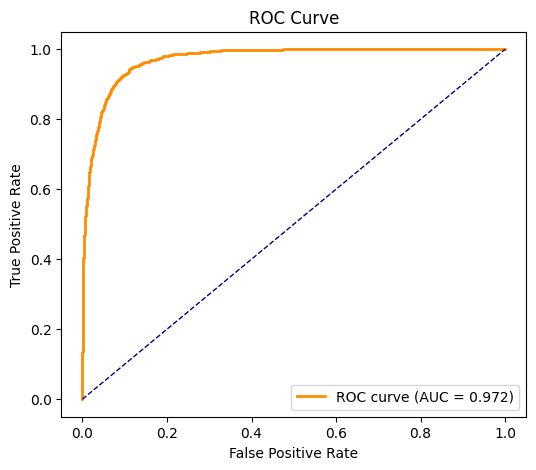

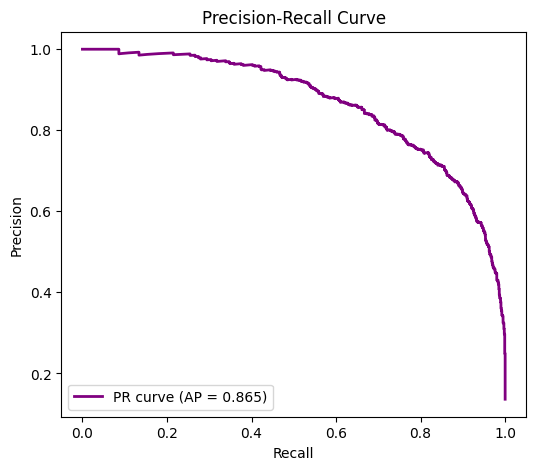

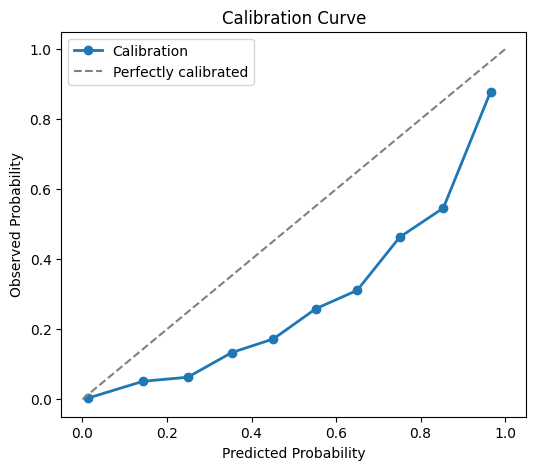

Brier Score Loss: 0.05791116979610158


In [5]:
# -------------------- Stage 1 - Precipitation classification --------------------
test_size = 0.15
val_size = 0.15
n = len(X)
test_split = int(n * (1 - test_size))
val_split = int(test_split * (1 - val_size))

X_train, y_train = X.iloc[:val_split], y.iloc[:val_split]
X_val, y_val = X.iloc[val_split:test_split], y.iloc[val_split:test_split]
X_test, y_test = X.iloc[test_split:], y.iloc[test_split:]

counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]


Classification_model = xgb.XGBClassifier(n_estimators=1000,
                                         learning_rate=0.01,
                                         max_depth=5,
                                         subsample=0.8,
                                         colsample_bytree=0.7,
                                         objective='binary:logistic',
                                         eval_metric= ['logloss', 'auc'],
                                         scale_pos_weight=scale_pos_weight,
                                         early_stopping_rounds=50,
                                         random_state=random_seed
                                         )


Classification_model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         verbose=False
                         )

y_pred_test = (Classification_model.predict_proba(X_test)[:,1] > prediction_threshold).astype(int)

print("\nStage 1: Precipitation Prediction Test Metrics")
print(classification_report(y_test, y_pred_test, zero_division=0))
print(confusion_matrix(y_test, y_pred_test))

y_prob_test = Classification_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob_test)
ap_score = average_precision_score(y_test, y_prob_test)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

prob_true, prob_pred = calibration_curve(y_test, y_prob_test, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Calibration')
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

brier_score = brier_score_loss(y_test, y_prob_test)
print("Brier Score Loss:", brier_score)


Stage 1: Precipitation Prediction Test Metrics After Calibration
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      6393
           1       0.75      0.79      0.77      1009

    accuracy                           0.94      7402
   macro avg       0.86      0.88      0.87      7402
weighted avg       0.94      0.94      0.94      7402

[[6132  261]
 [ 209  800]]


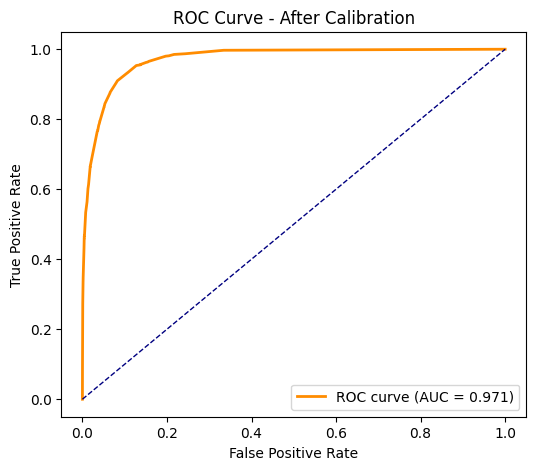

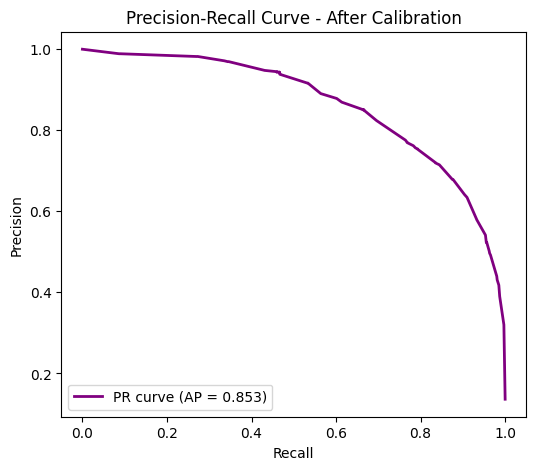

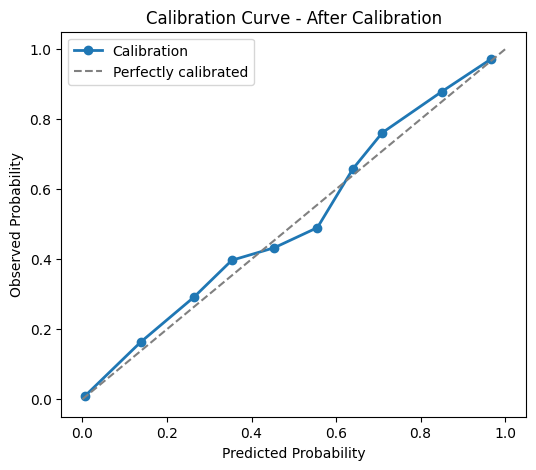

Brier Score Loss - After Calibration: 0.043433824619042015

Stage 1: Precipitation Prediction Train Metrics After Calibration
Train Accuracy: 0.96109396914446
Train Precision: 0.8574329813160032
Train Recall: 0.8604035051966579
Train F1: 0.8589156749059099
Train Brier: 0.028420925988228846


In [6]:
frozen_classifier = FrozenEstimator(Classification_model)

calibrated_Classification_model = CalibratedClassifierCV(estimator= frozen_classifier, method='isotonic')
calibrated_Classification_model.fit(X_val, y_val)

y_prob_test_cal = calibrated_Classification_model.predict_proba(X_test)[:,1]

y_pred_test_cal = (calibrated_Classification_model.predict_proba(X_test)[:,1] > prediction_threshold).astype(int)

print("\nStage 1: Precipitation Prediction Test Metrics After Calibration")
print(classification_report(y_test, y_pred_test_cal, zero_division=0))
print(confusion_matrix(y_test, y_pred_test_cal))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test_cal)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - After Calibration')
plt.legend(loc='lower right')
plt.show()

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob_test_cal)
ap_score = average_precision_score(y_test, y_prob_test_cal)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - After Calibration')
plt.legend(loc='lower left')
plt.show()

prob_true, prob_pred = calibration_curve(y_test, y_prob_test_cal, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Calibration')
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title('Calibration Curve - After Calibration')
plt.legend()
plt.show()

brier_score = brier_score_loss(y_test, y_prob_test_cal)
print("Brier Score Loss - After Calibration:", brier_score)

print("\nStage 1: Precipitation Prediction Train Metrics After Calibration")

y_train_pred = calibrated_Classification_model.predict(X_train)
y_train_prob = calibrated_Classification_model.predict_proba(X_train)[:,1]

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train Precision:", precision_score(y_train, y_train_pred))
print("Train Recall:", recall_score(y_train, y_train_pred))
print("Train F1:", f1_score(y_train, y_train_pred))
print("Train Brier:", brier_score_loss(y_train, y_train_prob))


In [7]:
# -------------------- Stage 2 - Predict amount of precipitation --------------------

rain_df = df[df['precipitation'] > 0].copy()
y_reg = rain_df['precipitation']
X_reg = rain_df.drop(['precipitation', 'weather_code', 'precipitation_forecast'], axis=1)

test_size = 0.15
val_size = 0.15

n2 = len(X_reg)
test_split2 = int(n2 * (1 - test_size))
val_split2 = int(test_split2 * (1 - val_size))

X2_train, y2_train = X_reg.iloc[:val_split2], y_reg.iloc[:val_split2]
X2_val, y2_val = X_reg.iloc[val_split2:test_split2], y_reg.iloc[val_split2:test_split2]
X2_test, y2_test = X_reg.iloc[test_split2:], y_reg.iloc[test_split2:]

y2_train_log = np.log1p(y2_train)
y2_val_log = np.log1p(y2_val)
y2_test_log = np.log1p(y2_test)

weights = np.log1p(y2_train.values)

print("\nCatboost training:")
train_pool = Pool(X2_train, label=y2_train_log, weight=weights)
val_pool = Pool(X2_val, label=y2_val_log)

cat_params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.003,
    'depth': 5,                 
    'l2_leaf_reg': 10,        
    'subsample': 0.5,          
    'rsm': 0.5,                
    'iterations': 3000,         
    'eval_metric': 'RMSE',
    'random_seed': random_seed,
    'verbose': 500,            
    'early_stopping_rounds': 50
}

Reg_model_cat = CatBoostRegressor(**cat_params)
Reg_model_cat.fit(train_pool, eval_set=val_pool, use_best_model=True)

pred_cat_train = Reg_model_cat.predict(X2_train)

pred_cat_test = Reg_model_cat.predict(X2_test)

y2_pred_train = np.expm1(pred_cat_train)
y2_pred_train_clipped = np.clip(y2_pred_train, 0, None)

y2_pred_test = np.expm1(pred_cat_test)
y2_pred_test_clipped = np.clip(y2_pred_test, 0, None)


print("\nStage 2: Precipitation Amount Regression Metrics")

print("Test RMSE:", np.sqrt(mean_squared_error(y2_test, y2_pred_test_clipped)))
print("Test MAE:", mean_absolute_error(y2_test, y2_pred_test_clipped))
print("Test R2:", r2_score(y2_test, y2_pred_test_clipped))

print("\nTrain RMSE:", np.sqrt(mean_squared_error(y2_train, y2_pred_train_clipped)))
print("Train MAE:", mean_absolute_error(y2_train, y2_pred_train_clipped))
print("Train R2:", r2_score(y2_train, y2_pred_train_clipped))

cat_importance = Reg_model_cat.get_feature_importance(train_pool)
cat_df = pd.DataFrame({
    'feature': X2_train.columns,
    'importance_cat': cat_importance
})
cat_df = cat_df.sort_values(by='importance_cat', ascending=False)

cat_df.to_csv('feature_importances_{}_{}.csv'.format(City, State), index=False)


Catboost training:
0:	learn: 0.6281711	test: 0.7148556	best: 0.7148556 (0)	total: 57.7ms	remaining: 2m 53s
500:	learn: 0.4426992	test: 0.5006987	best: 0.5006987 (500)	total: 3.03s	remaining: 15.1s
1000:	learn: 0.3870657	test: 0.4380072	best: 0.4380072 (1000)	total: 6.18s	remaining: 12.3s
1500:	learn: 0.3585394	test: 0.4094096	best: 0.4094096 (1500)	total: 9.4s	remaining: 9.39s
2000:	learn: 0.3390085	test: 0.3933945	best: 0.3933945 (2000)	total: 12.7s	remaining: 6.34s
2500:	learn: 0.3233617	test: 0.3819025	best: 0.3818859 (2498)	total: 16s	remaining: 3.19s
2999:	learn: 0.3091414	test: 0.3723543	best: 0.3723543 (2999)	total: 19.2s	remaining: 0us

bestTest = 0.3723542732
bestIteration = 2999


Stage 2: Precipitation Amount Regression Metrics
Test RMSE: 1.0000453642939635
Test MAE: 0.6404742720225501
Test R2: 0.5710419713873665

Train RMSE: 0.8635395304575475
Train MAE: 0.5607680274711804
Train R2: 0.7113797800326065
